In [1]:
# generic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# notebook settings
%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2 
# precision and plot settings
num_precision = 3
np.set_printoptions(precision=num_precision, suppress=True)
pd.set_option('display.float_format', lambda x: f'{x:,.{num_precision}f}')
pd.set_option("display.precision", num_precision)
pd.set_option('display.max_columns', None)
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['lines.linewidth'] = 2

In [2]:
# setup dir and import helper functions
import sys, os
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'src'))
import helper_funcs as my_funcs

In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import data
from tensorflow.keras import callbacks

In [4]:
directory = '../data/symlink_data/wild_est_test'

In [5]:
batch_size = 32
img_size = 256

In [6]:
# make a dataset of 2
X_train = image_dataset_from_directory(
    directory, labels='inferred', class_names=None, 
    color_mode='rgb', batch_size=batch_size, image_size=(img_size, img_size), shuffle=True, seed=42,
    validation_split=0.25, subset='training', interpolation='bilinear', follow_links=True
)

Found 8 files belonging to 2 classes.
Using 6 files for training.


In [7]:
X_test = image_dataset_from_directory(
    directory, labels='inferred', class_names=None, 
    color_mode='rgb', batch_size=batch_size, image_size=(img_size, img_size), shuffle=True, seed=42, 
    validation_split=0.25, subset='validation', interpolation='bilinear', follow_links=True
)

Found 8 files belonging to 2 classes.
Using 2 files for validation.


In [8]:
num_classes = 2
epochs = 1 
AUTOTUNE = data.experimental.AUTOTUNE
img_height = 256
img_width = 256
nb_filters = 32    # number of convolutional filters to use - want 1 for each "feature" you think exists in images if more, more parameters
pool_size = (2, 2)  # pooling decreases image size, reduces computation, adds translational invariance
kernel_size = (2, 2)  # convolutional kernel size, slides over image to learn features
X_train = X_train.cache().shuffle(32).prefetch(buffer_size=AUTOTUNE) 
X_test = X_test.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.Conv2D(nb_filters, (kernel_size[0], kernel_size[1]), padding='same', activation='relu'), # was 16, 32, 64
    layers.MaxPooling2D(pool_size=pool_size),
    layers.Conv2D(nb_filters*2, (kernel_size[0], kernel_size[1]), padding='same', activation='relu'), # drop layers.. for initial testing
    layers.MaxPooling2D(pool_size=pool_size),
    layers.Conv2D(nb_filters*3, (kernel_size[0], kernel_size[1]), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=pool_size),
    layers.Conv2D(nb_filters*4, (kernel_size[0], kernel_size[1]), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=pool_size),
    # insert more layers?
    # insert callback?
    layers.Flatten(),
    layers.Dense(256, activation='relu'), # increase this? add another dense layer?
    layers.Dropout(0.5),
    #layers.Dense(num_classes, activation='relu') # or sigmoid for binary? relu?
    layers.Dense(1, activation='sigmoid') # or sigmoid for binary? relu?
])

In [10]:
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])
              # if multiclass then use this:
              #loss = keras.losses.CategoricalCrossentropy(from_logits=True),
#               metrics = ['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      8

In [12]:
my_callbacks = [
    callbacks.EarlyStopping(patience=5),
#     callbacks.ModelCheckpoint(
#                         filepath='../data/tensorboard_models/model.{epoch:02d}-{val_loss:.2f}.h5', 
#                         monitor='val_loss', 
#                         verbose=0, 
#                         save_best_only=False,
#                         save_weights_only=False, 
#                         mode='auto', 
#                         save_freq='epoch', 
#                         options=None),
    callbacks.TensorBoard(log_dir='./logs',
                          histogram_freq=2,
                          write_graph=True,
                          write_images=True),
]

In [13]:
# run it
# try more epochs (maybe 1000.. at least 100)
history = model.fit(
            X_train,
            validation_data = X_test,
            epochs = 5,
            #batch_size=batch_size,
            verbose = 1,
            callbacks=my_callbacks
) # weighted_metrics

Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 0.6987 - accuracy: 0.5000 - val_loss: 1.0734 - val_accuracy: 0.5000
Epoch 2/5
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 0s 64ms/step - loss: 0.9496 - accuracy: 0.3333 - val_loss: 0.6893 - val_accuracy: 0.5000
Epoch 3/5
1/1 [==============================] - 1s 963ms/step - loss: 0.8932 - accuracy: 0.3333 - val_loss: 0.6958 - val_accuracy: 0.5000
Epoch 4/5
1/1 [==============================] - 0s 66ms/step - loss: 0.7490 - accuracy: 0.5000 - val_loss: 0.7098 - val_accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 1s 962ms/step - loss: 0.6911 - accuracy: 0.8333 - val_loss: 0.7118 - val_accuracy: 0.0000e+00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f90d2c37150>,
      dtype=object)

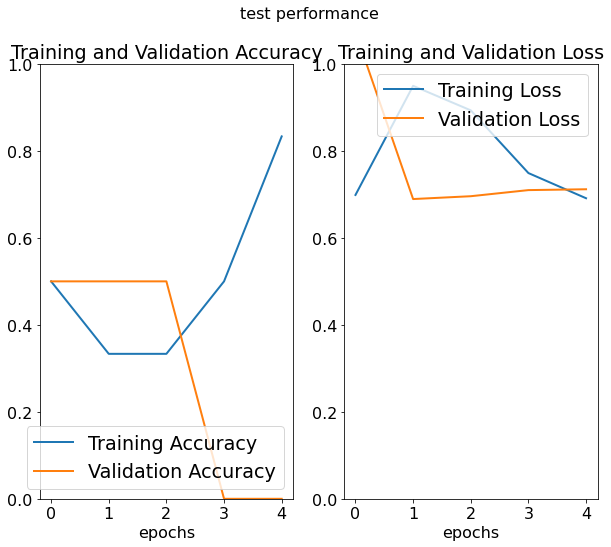

In [14]:
# testing this plot function
model_name = 'test'
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
my_funcs.plot_train_val_acc(history, 5, model_name, axs)

In [24]:
!tensorboard --logdir=logs

W0916 17:17:07.883781 123145341861888 plugin_event_accumulator.py:323] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0916 17:17:07.955417 123145341861888 plugin_event_accumulator.py:323] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0916 17:17:08.060293 123145341861888 plugin_event_accumulator.py:323] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0916 17:17:08.136718 123145341861888 plugin_event_accumulator.py:323] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0916 17:17:08.217406 12

In [26]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = \
    fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

4423680/4422102 [==============================] - 0s 0us/step


In [27]:
img = np.reshape(train_images[0], (-1, 28, 28, 1))

In [36]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [43]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [42]:
history = model.fit(
    train_images,
    train_labels,
    epochs=5,
    verbose=1,
    callbacks=my_callbacks,
    validation_data=(test_images, test_labels),
)

Epoch 1/5
1875/1875 [==============================] - 2s 883us/step - loss: 0.5536 - accuracy: 0.7893 - val_loss: 0.6516 - val_accuracy: 0.7792
Epoch 2/5
1875/1875 [==============================] - 2s 845us/step - loss: 0.5480 - accuracy: 0.8118 - val_loss: 0.7822 - val_accuracy: 0.7663
Epoch 3/5
1875/1875 [==============================] - 2s 804us/step - loss: 0.5350 - accuracy: 0.8154 - val_loss: 0.6547 - val_accuracy: 0.8035
Epoch 4/5
1875/1875 [==============================] - 1s 792us/step - loss: 0.5251 - accuracy: 0.8199 - val_loss: 0.6176 - val_accuracy: 0.8011
Epoch 5/5
1875/1875 [==============================] - 1s 786us/step - loss: 0.5213 - accuracy: 0.8221 - val_loss: 0.5950 - val_accuracy: 0.8193
